In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Reading and constructing dataframes 

In [14]:
# Paths to data and names of data files
DATA_URL = "https://usafactsstatic.blob.core.windows.net/public/data/covid-19/"
CONFIRMED_CASES = "covid_confirmed_usafacts.csv" # new covid cases in each county in the country each day from the beginning of the pandemic
DEATHS = "covid_deaths_usafacts.csv" # covid deaths in each county in the country each day from the beginning of the pandemic
POP_FACTS = "covid_county_population_usafacts.csv"

VACCINATIONS_URL = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv"

# read the data files into dataframes
cases_df_raw = pd.read_csv(DATA_URL + CONFIRMED_CASES)
deaths_df_raw = pd.read_csv(DATA_URL + DEATHS)
pop_df_raw = pd.read_csv(DATA_URL + POP_FACTS)
vacc_df = pd.read_csv(VACCINATIONS_URL)

states_abbrev_dict = {'State': {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
                                  'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
                                  'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois',
                                  'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana',
                                  'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan',
                                  'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana',
                                  'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
                                  'NM': 'New Mexico', 'NY': 'New York State', 'NC': 'North Carolina',
                                  'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon',
                                  'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
                                  'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah',
                                  'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
                                  'WI': 'Wisconsin', 'WY': 'Wyoming'}}

states_abbrev_df = pd.DataFrame.from_dict(states_abbrev_dict)\
                               .reset_index()\
                               .rename(columns={'index': 'Abbrev'})

### Formatting configurations for convenience

In [15]:
pd.options.display.float_format = '{:,}'.format # show large numbers with commas
pop_df_raw.population = pop_df_raw.population.astype(float) # cast as float to use float formatting
FIG_SIZE = (10, 6)

### Perform formatting of our dataframes to make manipulations easier later

In [16]:
# we don't need individual county data
cases_df = cases_df_raw.drop(columns=['StateFIPS', 'County Name', 'countyFIPS']).set_index('State')
deaths_df = deaths_df_raw.drop(columns=['StateFIPS', 'County Name', 'countyFIPS']).set_index('State')

# make sure all date columns are in datetime format
cases_df.columns = pd.to_datetime(cases_df.columns)
deaths_df.columns = pd.to_datetime(deaths_df.columns)
vacc_df['date'] = pd.to_datetime(vacc_df['date'])

# strip off the "time" part of datetime
cases_df.columns = cases_df.columns.date
deaths_df.columns = deaths_df.columns.date 
vacc_df['date'] = vacc_df['date'].dt.date

### Define some constants we will use frequently

In [17]:
case_max_date = cases_df.columns.max()
deaths_max_date = deaths_df.columns.max()
vacc_max_date = vacc_df['date'].max()

# in the off chance the 3 files are updated at different times, use the most recent one they all share for analysis
LATEST_DATE = min(case_max_date, deaths_max_date, vacc_max_date)

### Perform some preprocessing to make our dataframes consistent with each other

In [18]:
def trim_dataframe(dataframe, type_df):
    """trim_dataframe - Used to drop extra (too recent) dates from a dataframe
    so it matches our other dataframes. Determines this date using the LATEST_DATE
    global variable.
    :param dataframe: vaccination or cases/deaths dataframe. If vaccination, the 
                        'date' column must be in date format. If cases/deaths, the
                        columns must be in date format.
                    
    :param type_df: type of dataframe either 'vacc' for vaccine. Anything else is 
                    treated as a cases/deaths dataframe.
    :return: Dataframe of the same format with excess date columns/rows trimmed off.
    """
    if type_df == 'vacc':
        return_df = dataframe.drop(dataframe[dataframe['date'] > LATEST_DATE].index)
    else:
        bad_dates = dataframe.columns > LATEST_DATE
        return_df = dataframe.drop(columns=dataframe.columns[bad_dates])
        
    return return_df

In [19]:
# make sure all 3 datasaets use the same date range
vacc_df = trim_dataframe(vacc_df, 'vacc')
cases_df = trim_dataframe(cases_df, 'cases')
deaths_df = trim_dataframe(deaths_df, 'deaths')

# save total aggregate data of each state of the case/deaths instead of by date
cases_df_aggr = states_abbrev_df.merge(cases_df, left_on='Abbrev', right_index=True, how='right')\
                         .drop(columns='Abbrev')\
                         .set_index('State')\
                         .groupby(level=0)\
                         .sum()
deaths_df_aggr = states_abbrev_df.merge(deaths_df, left_on='Abbrev', right_index=True, how='right')\
                         .drop(columns='Abbrev')\
                         .set_index('State')\
                         .groupby(level=0)\
                         .sum()

# add state abbreviations to pop_df
pop_df = states_abbrev_df.merge(pop_df_raw, left_on='Abbrev', right_on='State', how='right')\
                         .drop(columns='State_y')\
                         .rename(columns={'State_x':'State'})

### Define the ways we can split up the locations of vacc_df

In [20]:
STATE_NAMES = pop_df['State'].unique().tolist()
TERRITORIES = ['American Samoa', # places we should consider separate from states AND separate from groups
               'Guam',
               'Northern Mariana Islands',
               'Puerto Rico',
               'Virgin Islands']
US_GROUP_NAMES = ['Bureau of Prisons', # groups within the US
                    'Dept of Defense',
                    'Indian Health Svc',
                    'Long Term Care',
                    'Veterans Health']
DISJOINT_ENTITIES = ['Federated States of Micronesia', # territories under US authority but not counted in US vaccination data
                        'Marshall Islands',
                        'Republic of Palau']

# vacc_df has the records for the following locations as well, we will explicitly add them to our dataframes as needed 
DC = ['District of Columbia']
US = ['United States']

# Question 1

In us_state_vaccinations.csv there are some gaps in the data. Will those gaps affect the
results of the following questions. If no why not. If yes explain the affect.

If somehow, the latest date in that file has gaps, we can use the commands below to find exactly which records have NaN values for the columns we care about. We actually only use 2 columns ("people_fully_vaccinated" and "people_vaccinated"), so we can only check if any of those columns are NaN for the date we care about. 

The section below can have FORWARD_FILL toggled to "True" and this will fill that location's vaccination data with the most recent data available. If only 2 data columns (eg. people_vaccinated and total_distributed) are missing for this date, this will only fill those 2 columns with the most recent data available. The remaining columnns remain untouched.

In [21]:
vacc_rows_we_care_about = vacc_df[['location', 'date', 'people_fully_vaccinated', 'people_vaccinated']]
null_records = vacc_rows_we_care_about[vacc_rows_we_care_about.isnull().any(axis=1)]
latest_date_null_records_mask = null_records['date']==LATEST_DATE

display(null_records[latest_date_null_records_mask].set_index('date'))

# save a copy for parts 5 and 6 (reasoning is below)
vacc_df_copy = vacc_df.copy()

# If we want, we can fill in those records using the command below to be the most recent counts available.
# Caution: using the forward fill below will require rerunning the entire notebook to restore the NaN values
FORWARD_FILL = False
if FORWARD_FILL:
    vacc_df = vacc_df.set_index('location').groupby(['location']).ffill().reset_index()

,location,people_fully_vaccinated,people_vaccinated
date,,,
2021-04-06,Long Term Care,NaN,NaN


Gaps in the data would not have a big impact on the below analysis. As mentioned, the only two columns we really use from the us_state_vaccinations.csv dataset are "people_fully_vaccinated" and "people_vaccinated". Both of these columns are totals and not daily amounts. If the most recent date is complete, then there is no real concern. Below are the impacts for each problem if there are any gaps:<BR>
&nbsp;&nbsp;&nbsp;&nbsp;(2): My analysis shows that the territory data is in the US total data. Therefore, gaps in the territory data will also have the same gaps in the US record. There won't be an impact.<BR>
&nbsp;&nbsp;&nbsp;&nbsp;(3): If any states are missing latest date data, the percentages will either be 0 or NaN for those states since we can't manipulate missing data. It will be obvious there's an issue since only those states will have 0 or NaN values. This can be mitigated with backfilling as mentioned above. <BR>
&nbsp;&nbsp;&nbsp;&nbsp;(4): This is using the exact same data as (3), but in graph format. So the same reasoning applies.<BR>
&nbsp;&nbsp;&nbsp;&nbsp;(5 and 6): We are using a weekly averages to get the percentage. Therefore, only if a state has an entire week missing or they reported it all on a single date for a week, there won't by much of a concern. If a week was missing completely, then we will see unexpected dips in the graph. If we have all the data for the week reported on a single date, the average will be that single value and we will see spike(s) in the graph. In this case, we would be better off not filling in the data using the forward fill above. This is because trends are still fairly easy to see even with these spikes and it would be easy to overcount the data by forward filling it.<BR>

# Question 2

The vaccination data is reported by the entire county, state, US territory, and various groups
like the department of defense, long term care and others. Presumably the US data includes the state data and the special group data but not the US territory data. Is the US territory data included in the US totals. Justify your answer.

In [23]:
def get_latest_subset_vacc(vacc_df, include_list, exclude_list=[]):
    """get_latest_subset_vacc - Used to get a select list of rows from the
    vacc_df dataframe matching the locations in the include_list and not in
    the optional exclude_list. The returned dataframe will only keep one row (the 
    latest date of data) for each name in the include_list. Uses global variable
    LATEST_DATE.
    :param vacc_df: vaccination dataframe of format (index=[], 
                                                    columns=[location, date, {other columns}])
    :param include_list: list of locations in the vacc_df we wish to have in our return.
    :param exclude_list: list of locations in the vacc_df we wish to NOT have in our return.
    :return: vaccination dataframe of only the rows we want for the latest date.
    """
    if exclude_list:
        include_list = [i for i in include_list if i not in exclude_list]
    vacc_by_loc = vacc_df.loc[vacc_df['location'].isin(include_list)]
    return vacc_by_loc[vacc_by_loc['date']==LATEST_DATE].drop(columns=['date'])

In [24]:
def get_latest_sum_by_group(vacc_df, names_list, exclude_list=[]):
    """get_latest_sum_by_group - Used to get the latest date of data for
    each named location and return the sum of all these items. In the case "US" is the
    first element of names, return the total US row entry only.
    :param vacc_df: vaccination dataframe of format (index=[], 
                                                    columns=[location, date, {other columns}])
    :param names: list of locations in the vacc_df we wish to include in our sum.
    :param exclude_list: list of locations in the vacc_df we do NOT want to include in the aggregate.
    :return: vaccination dataframe of a single row with the sums we want for the latest date.
             of the format (index=[], 
                            columns=[{other columns}])
    """
    if names_list[0] == US[0]:
        US_latest_mask = (vacc_df['location']==US[0]) & (vacc_df['date']==LATEST_DATE)
        sum_latest_vacc_by_group = vacc_df[US_latest_mask].drop(columns=['location','date'])\
                                                          .reset_index(drop=True)
    else:
        latest_vacc_by_group = get_latest_subset_vacc(vacc_df, names_list)\
                                            .drop(columns=['location'])
        sum_latest_vacc_by_group = latest_vacc_by_group.agg([sum])\
                                            .reset_index(drop=True)
    return sum_latest_vacc_by_group

In [25]:
# get the most recent totals of the different groups
us_vacc_to_date = get_latest_sum_by_group(vacc_df, US)
state_capitol_vacc_to_date = get_latest_sum_by_group(vacc_df, STATE_NAMES+DC)
territory_vacc_to_date =  get_latest_sum_by_group(vacc_df, TERRITORIES)
dj_entity_vacc_to_date =  get_latest_sum_by_group(vacc_df, DISJOINT_ENTITIES)

# find the sum of the state, capital, territories, and disjoint entities
state_capitol_territory_dj_vacc = state_capitol_vacc_to_date.add(territory_vacc_to_date).add(dj_entity_vacc_to_date)

# calulate the change
delta = us_vacc_to_date.sub(state_capitol_territory_dj_vacc)

# combine to a single output dataframe
totals = pd.concat([us_vacc_to_date,
                    state_capitol_territory_dj_vacc,
                    delta,
                    state_capitol_vacc_to_date,
                    territory_vacc_to_date,
                    dj_entity_vacc_to_date])\
           .reset_index(drop=True)
totals.insert(0, 'location', ['US totals', 'State, Capitol, and Territories','Delta (error)', 'State and Capitol', 'Territories', 'Disjoint Entities'])

# some columns are not important in this analysis since they are per thousand/million
totals.drop(columns=['people_fully_vaccinated_per_hundred',\
                     'total_vaccinations_per_hundred',\
                     'people_vaccinated_per_hundred',\
                     'distributed_per_hundred',\
                     'daily_vaccinations_per_million',\
                     'share_doses_used'],\
            inplace=True)

totals.set_index('location', inplace=True)

display(totals)

,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations
location,,,,,,
US totals,"168,592,075.0","219,194,215.0","108,301,234.0","63,016,976.0","1,404,280.0","2,998,533.0"
"State, Capitol, and Territories","167,909,866.0","219,194,215.0","107,512,394.0","62,582,780.0","1,397,454.0","2,988,229.0"
Delta (error),"682,209.0",0.0,"788,840.0","434,196.0","6,826.0","10,304.0"
State and Capitol,"166,466,649.0","216,617,035.0","106,584,137.0","62,035,890.0","1,390,657.0","2,968,147.0"
Territories,"1,381,845.0","2,456,780.0","890,763.0","522,665.0","6,318.0","19,637.0"
Disjoint Entities,"61,372.0","120,400.0","37,494.0","24,225.0",479.0,445.0


Rows 0-2 help show the discrepancy between the "US" record and the sum of rest of the records (not including the US groups) in the vaccination data. Rows 3-6 are just for reference of the breakdown of each location.

It seems that Territory data IS included in the US totals. Based on the results above, "total_distributed" matches exactly between the US total data and that of States+Capital+Territories. While none of the other records rows match exactly, this is likely due to human error or missing data. In all cases, the delta is less than a percent of US totals or State+Capital+Territories.

# Question 3

We would like to compute the percent of the population in each state that has been fully
vaccinated. Presumably the data reported for the various groups is not included in the individual state data. If we distributed the number of people fully vaccinated in those groups to
the states proportionally by population how much would that change the percent of people
vaccinated in each state?

As we will see below, distributing these groups to each state proportionally will increase the percent fully vaccinated by a constant amount (0.76% as of 3/26 data). It makes sense that each state increases by exactly the same percentage because we're distributing a fixed number accross each state proportionally. In other words, each state gets a number equivalent to how many number of people are in the state to begin with. In reality, this doesn't affect the total percent of people in each state fully vaccinated much since it's less than a 1% difference.

In [26]:
# column we wish to output data for
output_column = 'people_fully_vaccinated'

pop_by_state = pop_df.set_index('State')\
                     .groupby(['State'])\
                     .sum()['population']
US_pop = pop_by_state.sum()
pct_pop_by_state = (pop_by_state/US_pop)*100

# get people fully vacc'd in both state and US groups
fully_vacc_by_state = get_latest_subset_vacc(vacc_df, STATE_NAMES).set_index('location')[output_column]
fully_vacc_by_group = get_latest_subset_vacc(vacc_df, US_GROUP_NAMES)[output_column].sum()

# see how much each of the states should be allocated of the group data (by pop percentage)
fully_vacc_group_by_perc_state_pop = np.floor((pct_pop_by_state*fully_vacc_by_group)/100)
fully_vacc_group_distributed_to_states = (fully_vacc_by_state+fully_vacc_group_by_perc_state_pop)

# calculate what percent of people were vaccinated by state and how it changed by adding groups
pct_fully_vacc_by_state = ((fully_vacc_by_state/pop_by_state)*100).round(decimals=3)
pct_fully_vacc_group_distr_to_states = ((fully_vacc_group_distributed_to_states/pop_by_state)*100).round(decimals=3)
delta_pct = (pct_fully_vacc_group_distr_to_states - pct_fully_vacc_by_state).round(decimals=3)

# put all the data in a single dataframe for easy access
results_df = pd.DataFrame()
results_df = results_df.append([fully_vacc_by_state.rename('Vaccinations'),
                                fully_vacc_group_by_perc_state_pop.rename('Vaccinations for Groups by Population %'),
                                fully_vacc_group_distributed_to_states.rename('Vaccinations by Group distributed'),
                                pct_fully_vacc_by_state.rename('% Pop Fully Vaccinated (before distributing)'),
                                pct_fully_vacc_group_distr_to_states.rename('% Pop Fully Vaccinated (before distributing)'),
                                delta_pct.rename('Delta %')]).T
display(results_df)

,Vaccinations,Vaccinations for Groups by Population %,Vaccinations by Group distributed,% Pop Fully Vaccinated (before distributing),% Pop Fully Vaccinated (before distributing),Delta %
Alabama,"725,270.0","44,953.0","770,223.0",14.792,15.709,0.917
Alaska,"179,359.0","6,706.0","186,065.0",24.518,25.435,0.917
Arizona,"1,399,810.0","66,732.0","1,466,542.0",19.232,20.148,0.916
Arkansas,"489,479.0","27,667.0","517,146.0",16.22,17.137,0.917
California,"7,249,897.0","362,252.0","7,612,149.0",18.348,19.265,0.917
Colorado,"1,131,482.0","52,796.0","1,184,278.0",19.648,20.565,0.917
Connecticut,"843,076.0","32,686.0","875,762.0",23.647,24.564,0.917
Delaware,"178,965.0","8,927.0","187,892.0",18.379,19.295,0.916
Florida,"3,879,316.0","196,910.0","4,076,226.0",18.062,18.979,0.917
Georgia,"1,421,747.0","97,341.0","1,519,088.0",13.391,14.308,0.917


# Question 4

Produce a chart or table showing the percent of people in each state that have been fully
vaccinated. Sort the data by the percent of people vaccinated. You notebook should download the dataset so when it is run we get the most recent data.

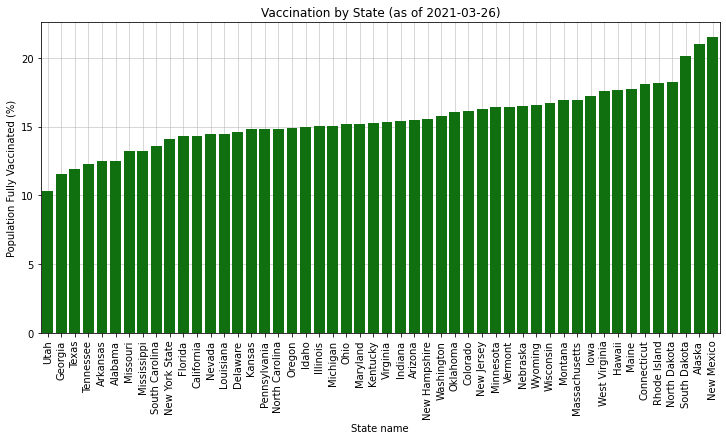

In [14]:
state_vacc_to_date =  get_latest_subset_vacc(vacc_df, STATE_NAMES).reset_index(drop=True)\
                                                                  .set_index('location')

fully_vacc_by_state_pct = ((state_vacc_to_date['people_fully_vaccinated']/pop_by_state)*100)\
                                                                                .sort_values(ascending=True)

# configure the graph
plt.figure(figsize=FIG_SIZE)
plot = sns.barplot(x=fully_vacc_by_state_pct.index,
                   y=fully_vacc_by_state_pct.values,
                   color='Green',
                   ci=None) # remove ci=None to add back the confidence interval
plt.xticks(rotation=90)
plt.tight_layout()
plot.set(xlabel = 'State name',
         ylabel = 'Population Fully Vaccinated (%)', 
         title='Vaccination by State (as of '+ str(LATEST_DATE)+')')
plot.set_axisbelow(True)
plt.grid(linewidth=0.5, linestyle='-')
plt.show()

# display the data by state if you want to see individual values of each state
#display(fully_vacc_by_state_pct.rename('Percent Fully Vaccinated').to_frame())

# Question 5

We want to see the progression from the start of the pandemic to now the percent of people that have some immunity in the US. Produce a plot of weekly data that contains three
lines. One showing the the percent of the living people have have or had covid. One showing the the percent of people that have had at least one covid vaccine shot. The third line
showing the sum of the two to estimate the number of people that have some immunity.
Over time sum will be an over estimate as people who had covid get a vaccine shot. As in
#4 the notebook should download the data to up-to-date results.

In [31]:
def seven_day_average(series):
    """seven_day_average - Used to compute the seven day average of the data in a series.
    Assumes the series indices are all able to be put into datetime format.
    :param series: vaccination dataframe of format (index=dates, 
                                                    values=numeric values to average on])
    :return: Series averaged by week.
    :side effect: will drop the first week if it's not complete (7 days).
    """
    series.index = pd.to_datetime(series.index)
    weekly_average = series.resample('W-MON', label='left', closed='left').mean()
    
    # if a full first week of data is not available, drop the first week
    if (weekly_average.index[1] - series.index[0]).days % 7 != 0:
        weekly_average.drop(weekly_average.index[0], inplace=True)
    
    return weekly_average

In [32]:
def get_pct_living_had_covid(cases_df_aggr, deaths_df_aggr, pop_state_df):
    """get_pct_living_had_covid - Used to calculate the percent living in a location (US or state)
    who had covid by subtracting deaths per location from cases per location.
    :param cases_df_aggr: cases dataframe of format (index=['location'], 
                                                    columns=cases by date list(aggregated daily))
    :param deaths_df_aggr: deaths dataframe of format (index=['location'], 
                                                    columns=deaths by date list(aggregated daily))
    :param pop_state_df: population dataframe of format (index=['location'], 
                                                    columns=[population of the location])
    :return: dataframe of the format (index=['State'], 
                                        columns=[percent living per location who had covid])
    """
    latest_living_had_covid_by_state = cases_df_aggr - deaths_df_aggr

    # used to get pop per state
    latest_living_had_covid_by_state = pop_by_state.merge(latest_living_had_covid_by_state, 
                                                          left_index=True, 
                                                          right_index=True)
    
    # to have our state and US total data in one dataframe
    latest_living_had_covid_by_US = latest_living_had_covid_by_state.sum().rename(US[0])
    latest_living_had_covid_all = latest_living_had_covid_by_state.append(latest_living_had_covid_by_US)
    
    # calculate the percent
    pct_living_by_location = 100*(latest_living_had_covid_all.iloc[:, 1:]\
                                  .div(latest_living_had_covid_all.population, axis=0))

    return pct_living_by_location

In [33]:
def get_pct_had_one_shot(vacc_df, pop_state_df):
    """get_pct_had_one_shot - Used to calculate the percent of people in a location (US or state) who had covid
    by subtracting deaths per state from cases per state.
    :param vacc_df: vaccination dataframe of format (index=['location'], 
                                                    columns=[date, location, total_vaccinations, total_distributed, 
                                                            people_vaccinated, people_fully_vaccinated_per_hundred, 
                                                            total_vaccinations_per_hundred, people_fully_vaccinated,
                                                            people_vaccinated_per_hundred, distributed_per_hundred,
                                                            daily_vaccinations_raw,	daily_vaccinations, 
                                                            daily_vaccinations_per_million, share_doses_used])
    :param pop_state_df: population dataframe of format (index=['location'], 
                                                    columns=[population of the location])
    :return: dataframe of the format (index=['State'], 
                                        columns=[percent with at least one shot per location])
    """
    # get only states and US total from the vacc_df
    vacc_by_state_by_date = vacc_df.loc[vacc_df['location']\
                                   .isin(STATE_NAMES+US)]

    # extract the desired column
    vacc_by_state_by_date.set_index(['date', 'location'], inplace=True)
    at_least_one_shot_by_date = vacc_by_state_by_date['people_vaccinated'].unstack().T
    
    # to have our state and US total data in one dataframe
    US_pop = pop_state_df.sum().rename(US[0])
    pop_state_df = pop_state_df.append(US_pop)
    
    # calculate the percent
    pct_one_shot_by_location = 100*(at_least_one_shot_by_date\
                                  .div(pop_state_df.population, axis=0))
    
    # truncate datetime columns back to date only
    pct_one_shot_by_location.columns = pct_one_shot_by_location.columns.date

    return pct_one_shot_by_location

In [34]:
def match_date_range(pct_had_covid, pct_had_shot):
    """match_date_range - Used to take two dataframes with the same columns (dates) and index
    (states) and make sure they cover the same date range by zero filling if needed.
    :param pct_had_covid: dataframe of the format (index=['State'], 
                                        columns=[percent living per location who had covid])
    :param pct_had_shot: dataframe of the format (index=['State'], 
                                        columns=[percent with at least one shot per location])
    :return: same as params but with matching start and end date ranges (0 filled)
    """
    min_date = min(min(pct_had_covid.columns.values), min(pct_had_shot.columns.values))
    max_date = LATEST_DATE
    
    fill_range = pd.date_range(min_date, max_date)
    
    # reindex will only fill datest that are missing within our fill_range
    pct_had_covid_filled = pct_had_covid.T.reindex(fill_range, fill_value=0).T
    pct_had_shot_filled = pct_had_shot.T.reindex(fill_range, fill_value=0).T
    
    return (pct_had_covid_filled, pct_had_shot_filled)

In [35]:
def plot_location_vacc_stats(pct_had_covid_df, one_vacc_df, loc):
    """plot_location_vacc_stats - Uses to take in 2 dataframes with dates as column values and
    states index values. Prints the sum of the two values for the specified state as well as the
    individual two values. Columns must match.
    :param pct_had_covid: dataframe of the format (index=['State'], 
                                        columns=[percent living per location who had covid])
    :param pct_had_shot: dataframe of the format (index=['State'], 
                                        columns=[percent with at least one shot per location])
    :param loc: The two letter abbreviation for what location you want to print. It can be 'US'
                for US totals or the two letter abbreviation for the state you want (See 
                states_abbrev_dict at the beginning of the notebook).
    :return: None
    :side effect: plots a line plot with 3 lines as outlined above.
    """
    # Translate 2 letter abbrev to the location name expanded
    if loc == 'US':
        loc = US[0]
    else:
        loc = states_abbrev_dict['State'][loc]
    
    # calulate the percentages needed
    pct_loc_had_covid_alive = pct_had_covid_df.loc[loc]
    pct_loc_had_one_shot = one_vacc_df.loc[loc]
    sum_loc = pct_loc_had_one_shot + pct_loc_had_covid_alive
    
    # take the weekly average
    avg_pct_loc_had_covid_alive = seven_day_average(pct_loc_had_covid_alive)
    avg_pct_loc_had_one_shot = seven_day_average(pct_loc_had_one_shot)
    avg_sum_loc = seven_day_average(sum_loc)

    # plot the graph
    plt.figure(figsize=FIG_SIZE)
    plot = sns.lineplot(x=avg_pct_loc_had_covid_alive.index,
                        y=avg_pct_loc_had_covid_alive.values,
                        color='Green',
                        ci=None) # remove ci=None to add back the confidence interval
    plot = sns.lineplot(x=avg_pct_loc_had_one_shot.index, 
                        y=avg_pct_loc_had_one_shot.values,
                        color='Red',
                        ci=None)
    plot = sns.lineplot(x=avg_sum_loc.index,
                        y=avg_sum_loc.values,
                        color='Blue',
                        ci=None) 
    plt.legend(['Percent with >= 1 vaccine shot',
                'Alive and had Covid',
                'Sum (total immune estimate)'])
    plt.xticks(avg_sum_loc.index, rotation=70)
    plt.tight_layout()
    plot.set(xlabel = 'Week',
             ylabel = 'Population immune (%)',
             title=loc+' Immunity (as of '+ str(LATEST_DATE)+')')
    plot.set_axisbelow(True)
    plt.grid(linewidth=0.5, linestyle='-')
    plt.show()

In [36]:
pop_by_state = pop_df.groupby(['Abbrev', 'State'])\
                        .sum('population')\
                        .drop(columns=['countyFIPS'])\
                        .reset_index(level=0, drop=True)

# if we chose to forward fill for parts 2-4 earlier, that would not be good for this problem since
# we can easily overcount the weekly data if a state reports all their 
vacc_df = vacc_df_copy

# get statistics we want in percent
pct_living_had_covid_df = get_pct_living_had_covid(cases_df_aggr, deaths_df_aggr, pop_by_state)
pct_had_at_least_one_shot = get_pct_had_one_shot(vacc_df, pop_by_state)

# make sure the start date ranges match in both datasets, backfill with 0's
had_covid_pct, one_shot_pct = match_date_range(pct_living_had_covid_df, pct_had_at_least_one_shot)

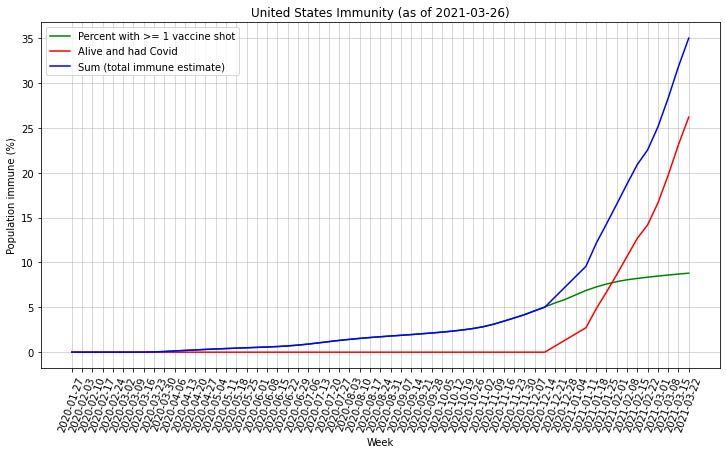

In [37]:
plot_location_vacc_stats(had_covid_pct, one_shot_pct, 'US')

# Question 6

Produce the same plot as in #5 for the states. You should have a function that takes the two
letter abbreviation for the state and produces the plot for the state. 

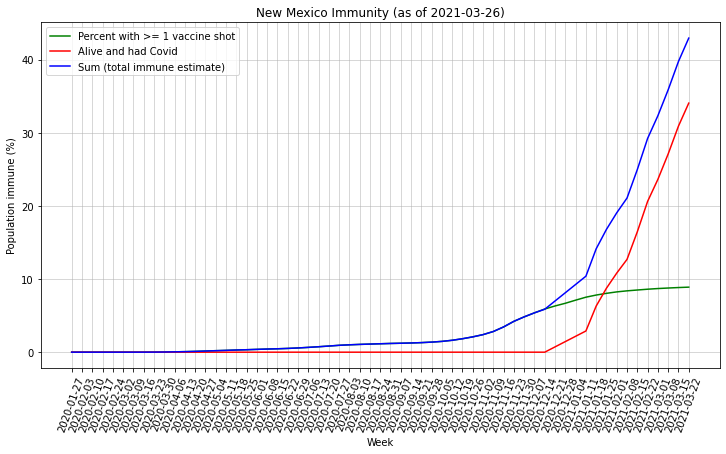

In [42]:
STATE = 'NM'
plot_location_vacc_stats(had_covid_pct, one_shot_pct, STATE)